|Variable|Variável     |Definição	                              |Chave                                         |
|--------|-------------|------------------------------------------|----------------------------------------------|
|survival|sobrevivência|Sobrevivência                             |0 = Não, 1 = Sim                              |
|pclass  |pclass	   |Classe de ingresso                        |1 = 1º, 2 = 2º, 3 = 3º                        |
|ex      |sexo         |Sexo                                      |                                              |
|Age     |Idade em anos| -                                        |                                              |
|sibsp   |sibsp        |Nº de irmãos / cônjuges a bordo do Titanic|	                                             |
|parch   |pergaminho   |Nº de pais / filhos a bordo do Titanic    |                                              |
|ticket  |bilhete      |Número do bilhete	                      |                                              |
|fare    |tarifa       |Tarifa de passageiro                      |	                                             |
|cabin   |cabine       |Número da cabine	                      |                                              |
|embarked|embarcou     |Porto de embarcação                       |C = Cherbourg, Q = Queenstown, S = Southampton|

In [56]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [181]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [182]:
# Convertendo em binario
transf = {"male": 0, "female": 1}

train['Sex_bin'] = train['Sex'].map(transf).astype(int)
test['Sex_bin'] = test['Sex'].map(transf).astype(int)

In [163]:
# # Convertendo ticket para numeric
# train['Ticket'] = train['Ticket'].str.replace(r'\D', '')
# train['Ticket'] = pd.to_numeric(train['Ticket'])

In [184]:
train['Embarked'] = train['Embarked'].fillna('S')

cab = {"S":1, "C":2, "Q":3}

train['Embarked'] = train['Embarked'].map(cab).astype(int)
test['Embarked'] = test['Embarked'].map(cab).astype(int)

In [185]:
# df = train.rename(columns={'SibSp':'ir/conj', 'Parch':'pais/filhos'})

In [186]:
# df.groupby('Embarked')['Embarked'].count()

In [187]:
# df['Embarked'].hist()

In [188]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


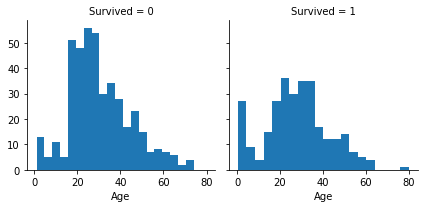

In [189]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [190]:
combine = [train,test]

In [191]:
print("Antes", train.shape, test.shape, combine[0].shape, combine[1].shape)
print("-"*50)

Antes (891, 13) (418, 12) (891, 13) (418, 12)
--------------------------------------------------


In [192]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [193]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()    

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [194]:
title = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,2,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,1,0,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,3,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,1,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,1,0,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,1,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,2,1,3


In [195]:
m = train['Age'].median()
train['Age'] = train['Age'].fillna(m)
test['Age'] = test['Age'].fillna(m)

In [196]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,2,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,1,1,3
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,1,0,1


In [197]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,2,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,1,1,3
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,1.0,0,0,211536,13.0000,NaN,1,0,5
887,888,1,1,"Graham, Miss. Margaret Edith",female,1.0,0,0,112053,30.0000,B42,1,1,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1.0,1,2,W./C. 6607,23.4500,NaN,1,1,2
889,890,1,1,"Behr, Mr. Karl Howell",male,1.0,0,0,111369,30.0000,C148,2,0,1
